In [1]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

In [7]:
df = pd.read_csv("data/沪深300天级别数据.csv",header=0,index_col=None,sep='\s+',parse_dates=[0])

In [8]:
df.head(8)

,time,open,close,high,low,volume,money
0,2012-01-04,2361.50,2298.75,2365.99,2298.30,3434456700,32572551267
1,2012-01-05,2290.78,2276.39,2316.66,2272.15,4301648000,37635272074
2,2012-01-06,2274.35,2290.60,2291.89,2254.57,3519899200,31079362325
3,2012-01-09,2291.18,2368.57,2368.89,2271.72,5472734100,51478126954
4,2012-01-10,2365.77,2447.35,2449.95,2361.28,8115498900,75249157103
5,2012-01-11,2444.76,2435.61,2453.15,2423.32,5870567400,57587219272
6,2012-01-12,2426.82,2435.22,2464.38,2423.32,4712127500,47877407259
7,2012-01-13,2438.41,2394.33,2445.79,2374.55,4551399700,47228338588


In [9]:
df.shape

(2024, 7)

In [10]:
df_feature = df[['close','open','high', 'low', 'volume', 'money']].astype('float')

In [11]:
sample_num = df.shape[0]

In [12]:
train_num = int(df.shape[0] * 0.8)

In [13]:
test_num = df.shape[0] - train_num

In [14]:
sample_num,train_num,test_num

(2024, 1619, 405)

In [15]:
data_train = df_feature.iloc[:train_num, :]
data_test = df_feature.iloc[train_num:, :]
print(data_train.shape, data_test.shape)

(1619, 6) (405, 6)


In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [18]:
data_train_y = np.array(df_feature.iloc[:train_num, 0])
data_test_y = np.array(df_feature.iloc[train_num:, 0])
print(data_train_y.shape, data_test_y.shape)

(1619,) (405,)


In [19]:
PAST_TIME_STEPS = 10
NEXT_TIME_STEPS = 3

In [20]:
X_train = np.array([data_train[i : i + PAST_TIME_STEPS, :] for i in range(0,data_train.shape[0] - (NEXT_TIME_STEPS+ PAST_TIME_STEPS),1)])
X_test = np.array([data_test[i : i + PAST_TIME_STEPS, :] for i in range(0,data_test.shape[0] - (NEXT_TIME_STEPS+ PAST_TIME_STEPS),1)])


In [21]:
y_train_class = np.array([1 if data_train_y[i + PAST_TIME_STEPS + NEXT_TIME_STEPS] - data_train_y[i + PAST_TIME_STEPS] > 0 else 0 for i in range(0,data_train.shape[0] - (NEXT_TIME_STEPS+ PAST_TIME_STEPS),1)])
y_test_class = np.array([1 if data_test_y[i + PAST_TIME_STEPS + NEXT_TIME_STEPS]- data_test_y[i + PAST_TIME_STEPS] > 0 else 0 for i in range(0,data_test.shape[0] - (NEXT_TIME_STEPS+ PAST_TIME_STEPS),1)])

In [22]:
print(X_train.shape, y_train_class.shape, X_test.shape,y_test_class.shape)

(1606, 10, 6) (1606,) (392, 10, 6) (392,)


In [23]:
INPUT_DIM = data_train.shape[1]
output_dim = 1
batch_size = 32 #每轮训练模型时，样本的数量
epochs = 100 #训练60轮次
hidden_size = 64
lstm_units = 32

In [24]:
inputs = Input(shape=(PAST_TIME_STEPS, INPUT_DIM))
#drop1 = Dropout(0.3)(inputs)
x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
#x = Conv1D(filters=128, kernel_size=5, activation='relu')(output1)#embedded_sequences
x = MaxPooling1D(pool_size = PAST_TIME_STEPS)(x)
x = Dropout(0.1)(x)
print(x.shape)

(?, 1, 64)


In [25]:
lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#lstm_out = LSTM(lstm_units,activation='relu')(x)
print(lstm_out.shape)

(?, 64)


In [26]:
# ATTENTION PART STARTS HERE
attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(lstm_out)
#attention_mul=layers.merge([stm_out,attention_probs], output_shape],mode='concat',concat_axis=1))
attention_mul =Multiply()([lstm_out, attention_probs])
#attention_mul = merge([lstm_out, attention_probs],output_shape=32, name='attention_mul', mode='mul')

In [27]:
output_class = Dense(1, activation='sigmoid')(attention_mul)
#output = Dense(10, activation='sigmoid')(drop2)

model_class = Model(inputs=inputs, outputs=output_class)
print(model_class.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 6)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 64)       448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 1, 64)        0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1, 64)        0           max_pooling1d_1[0][0]            
__________________________________________________________________________________________________
bilstm (Bi

In [28]:
#model_class.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_class.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# fit model
history_class = model_class.fit(X_train, y_train_class,validation_data=(X_test, y_test_class), epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=[es])
y_pred_class = model_class.predict(X_test)

Train on 1606 samples, validate on 392 samples
Epoch 1/100
1606/1606 [==============================] - 2s 1ms/step - loss: 0.6930 - acc: 0.5019 - val_loss: 0.6923 - val_acc: 0.5281
Epoch 2/100
1606/1606 [==============================] - 0s 120us/step - loss: 0.6925 - acc: 0.5255 - val_loss: 0.6920 - val_acc: 0.5281
Epoch 3/100
1606/1606 [==============================] - 0s 119us/step - loss: 0.6920 - acc: 0.5255 - val_loss: 0.6920 - val_acc: 0.5281
Epoch 4/100
1606/1606 [==============================] - 0s 123us/step - loss: 0.6921 - acc: 0.5255 - val_loss: 0.6921 - val_acc: 0.5281
Epoch 5/100
1606/1606 [==============================] - 0s 111us/step - loss: 0.6920 - acc: 0.5255 - val_loss: 0.6923 - val_acc: 0.5281
Epoch 6/100
1606/1606 [==============================] - 0s 119us/step - loss: 0.6919 - acc: 0.5255 - val_loss: 0.6924 - val_acc: 0.5281
Epoch 7/100
1606/1606 [==============================] - 0s 114us/step - loss: 0.6922 - acc: 0.5255 - val_loss: 0.6924 - val_acc: 0.5

In [29]:
# evaluate the model
_, train_acc = model_class.evaluate(X_train, y_train_class, verbose=1)
_, test_acc = model_class.evaluate(X_test, y_test_class, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

392/392 [==============================] - 0s 56us/step
Train: 0.526, Test: 0.528


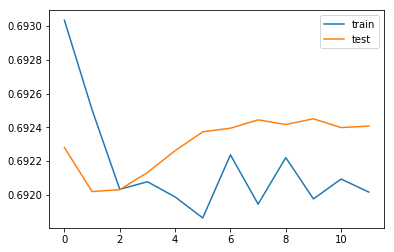

In [30]:
# plot training history
plt.plot(history_class.history['loss'], label='train')
plt.plot(history_class.history['val_loss'], label='test')
plt.legend()
plt.show()